In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

import statsmodels
from statsmodels.stats.anova import AnovaRM


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
import bootstrap_confidence
bootstrap_confidence.bootstrap_correct_incorrect_allbounds(n_boot_iter=1000)

0
1
2
3
4
5
6


In [4]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [5]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [6]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [10]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_sepcorrect_bootstrap_allbounds.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_sepcorrect_boot = b['signedconf_hardtrials_sepcorrect_boot']
axis_names = ['Axis 1','Axis 2','Checker']


In [9]:
signedconf_hardtrials_sepcorrect_boot.shape


(7, 8, 3, 3, 2, 1000)

#### older version (centermost trials only)

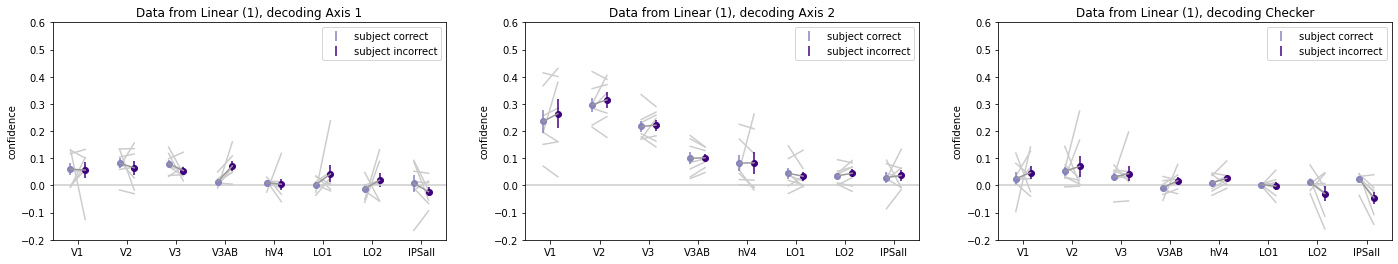

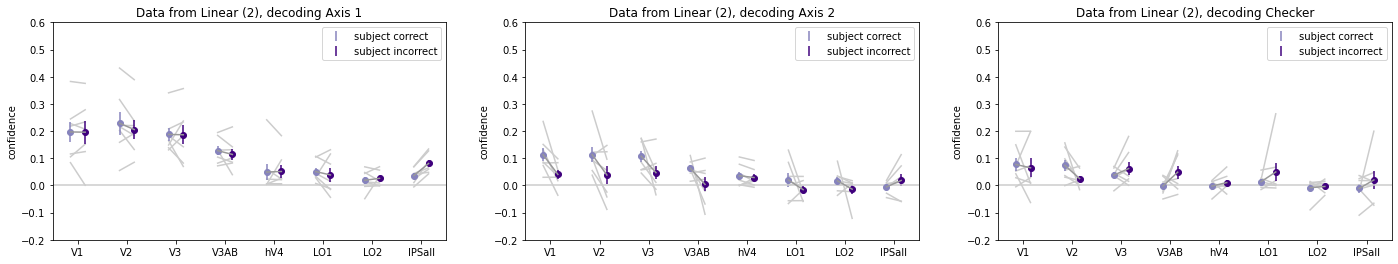

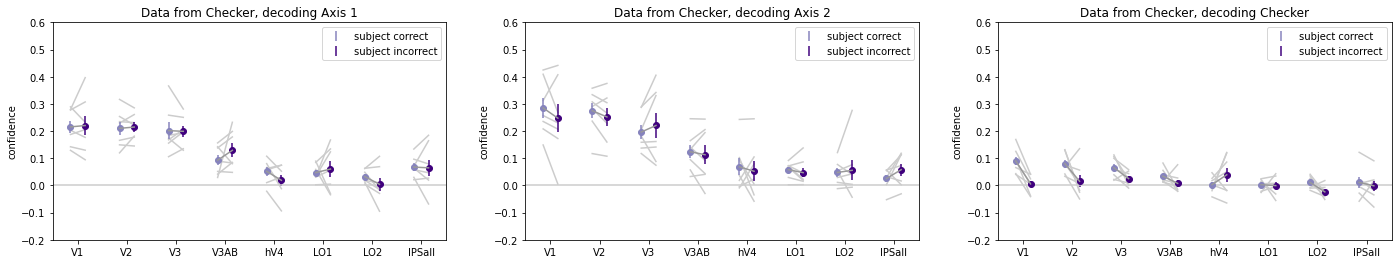

In [18]:
vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=5)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ti in [0,1,2]:

    
    plt.figure(figsize=(24,4))

    for ii, axis in enumerate(axis_names):

        plt.subplot(1,3,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ci in [0,1]:

            x_ticks = np.arange(n_rois) + x_jitter[ci]

            plt.plot(x_ticks, meanvals[:,ti,ii,ci], 'o', color=colors[ci])
            h = plt.errorbar(x_ticks, meanvals[:,ti,ii,ci], \
                             semvals[:,ti,ii,ci], \
                             xerr=None, color=colors[ci], linestyle='none')
            lh.append(h)

        for ri in range(n_rois):

            plt.plot(ri+x_jitter, meanvals[ri,ti,ii,:],'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, vals[:,ri,ti,ii,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
            # if non_overlapping[ri]:
            #     yval = np.max(cihigh[ri,ti,:])+0.02
            #     plt.annotate('*',[ri,yval])

        plt.ylim([-0.20, 0.60])
        # plt.ylim([-0.05, 0.20])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,['subject correct','subject incorrect'])

        plt.title('Data from %s, decoding %s'%(task_names[ti], axis))

    # plt.suptitle('Classifier confidence, %s task, hard trials only'%task_names[ti])


In [17]:
for ti, taskname in enumerate(task_names[0:3]):

    for ii, axis in enumerate(axis_names):

        vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=5)[:,:,ti,ii,:]

        anova_result = stats_utils.rmanova_2way(vals, ['roi','correctness'], do_shuffle=False)

        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
        print('\n%s task, decoding %s'%(taskname, axis))
        print(anova_result)


Linear (1) task, decoding Axis 1
                  F Value  Num DF  Den DF  Pr > F
roi              4.488144     7.0    42.0  0.0008
correctness      0.193370     1.0     6.0  0.6755
roi:correctness  1.100651     7.0    42.0  0.3805

Linear (1) task, decoding Axis 2
                   F Value  Num DF  Den DF  Pr > F
roi              23.139927     7.0    42.0  0.0000
correctness       0.473874     1.0     6.0  0.5169
roi:correctness   0.318723     7.0    42.0  0.9414

Linear (1) task, decoding Checker
                  F Value  Num DF  Den DF  Pr > F
roi              3.810541     7.0    42.0  0.0027
correctness      0.023874     1.0     6.0  0.8823
roi:correctness  1.642224     7.0    42.0  0.1502

Linear (2) task, decoding Axis 1
                   F Value  Num DF  Den DF  Pr > F
roi              11.302049     7.0    42.0  0.0000
correctness       0.000759     1.0     6.0  0.9789
roi:correctness   1.585152     7.0    42.0  0.1665

Linear (2) task, decoding Axis 2
                  F V